In [1]:
import os
nthreads = 10
os.environ["OMP_NUM_THREADS"] = str(nthreads)
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads)
os.environ["MKL_NUM_THREADS"] = str(nthreads)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.interpolate import griddata, RBFInterpolator, NearestNDInterpolator, LinearNDInterpolator

In [3]:
import inferagni as ia

In [4]:
datadir = "../src/inferagni/data/"
gr = ia.grid.Grid(datadir)

Loading data from CSV files...
Data directory: ../src/inferagni/data/
Grid size: 264600
Input vars:  ['index', 'worker', 'frac_atm', 'frac_core', 'mass_tot', 'logCO', 'logZ', 'instellation', 'Teff']
Output vars: ['index', 'succ', 'flux_loss', 'r_bound', 'p_surf', 't_surf', 'r_surf', 'μ_surf', 'g_surf', 't_phot', 'r_phot', 'μ_phot', 'g_phot', 'vmr_H2', 'vmr_H2O', 'vmr_CO2', 'vmr_CO', 'vmr_O2', 'vmr_OH', 'vmr_NH3', 'vmr_NO2', 'vmr_N2', 'vmr_SO2', 'vmr_H2S', 'vmr_H2SO4', 'Kzz_max', 'conv_ptop', 'conv_pbot']
Loaded data


In [5]:
gr.show_inputs();

frac_atm    
	- [0.001   0.00251 0.0063  0.0158  0.0397  0.0996  0.25   ]
frac_core   
	- [0.2   0.325 0.7  ]
mass_tot    
	- [ 1.     1.24   1.537  1.905  2.362  2.928  3.63   4.5    5.044  5.653
  6.336  7.102  7.96   8.922 10.   ]
logCO       
	- [-3. -2. -1.  0.]
logZ        
	- [-2.  -1.5 -1.  -0.5  0.   0.5  1. ]
instellation
	- [   1.   10.  100.  300. 1000.]
Teff        
	- [2500. 3150. 3800. 4450. 5100. 5750.]


Plot instellation, frac_atm
Filter by logZ = 0.5
Filter by logCO = -1
Filter by frac_core = 0.325
Filter by Teff = 4450
Number of points: 500
vmin:1.0    vmax:1000.0


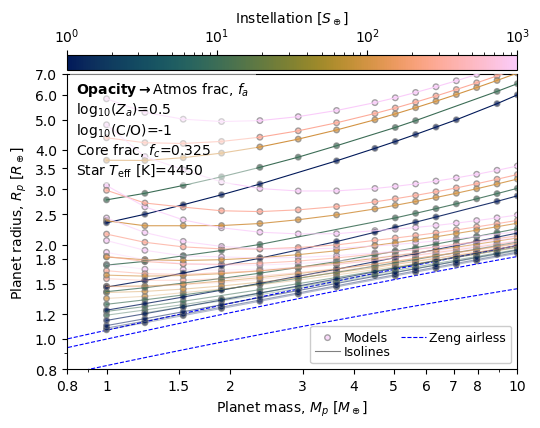

In [6]:
opts = {
    "key1"    : "instellation",
    "key2"    : "frac_atm",
    "controls": {"logZ":0.5, "logCO":-1,  "frac_core":0.325, "Teff":4450},
    "show_scatter" : True,
    "show_isolines" : True,
}

fig = ia.plot.massrad_2d(gr, **opts)
plt.show(fig)

Filter by frac_atm = 0.0063
Filter by frac_core = 0.325
Filter by logZ = 0
Filter by Teff = 4450
Filter by logCO = -1
Number of points: 74
x range: 1.00 - 10.00
y range: 1.29 - 6.12


/tmp/ipykernel_13807/4241000699.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  fig.colorbar(sm, label=ia.plot.units[zkey][2]).ax.set_yscale("log")


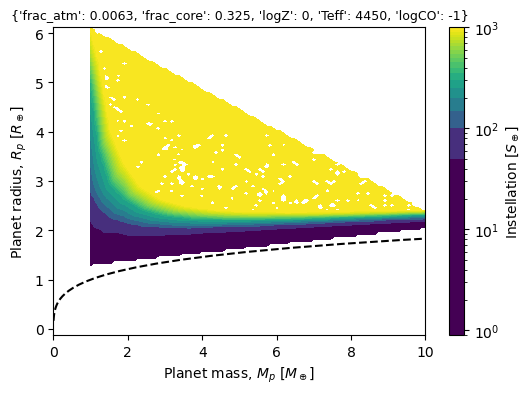

Filter by frac_core = 0.325
Filter by logZ = 0.0
Filter by instellation = 10.0
Filter by Teff = 4450
Filter by logCO = -1
Number of points: 97
x range: 1.00 - 10.00
y range: 1.49 - 12.65


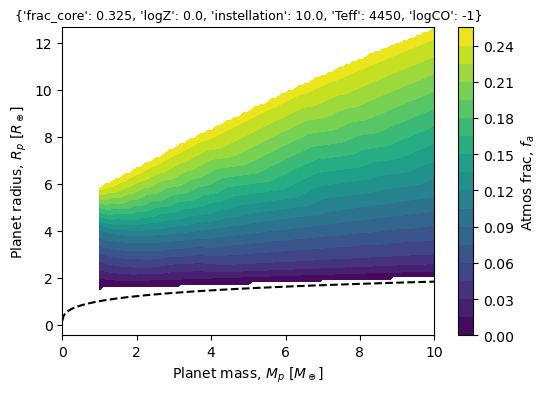

In [24]:
zkey = "instellation"
controls =  {"frac_atm":0.0063, "frac_core":0.325, "logZ":0, "Teff":4450, "logCO":-1}
itp_x, itp_y, itp_z = gr.interpolate_2d(controls=controls,
                                     zkey=zkey,
                                     resolution=100, method='linear')

fig,ax = plt.subplots(1,1,figsize=(6,4))
sm = ax.contourf(itp_x, itp_y, itp_z, levels=20, cmap='viridis', norm='log')
ax.plot(ia.plot.zeng[0.325][0],ia.plot.zeng[0.325][1], c='k', ls='--', label="Zeng+2019")
ax.set(xlabel=ia.plot.units["mass_tot"][2], ylabel=ia.plot.units["r_phot"][2], xlim=(0,10))
ax.set_title(f"{controls}", fontsize=9)
fig.colorbar(sm, label=ia.plot.units[zkey][2]).ax.set_yscale("log")
plt.show(fig)


zkey = "frac_atm"
controls={"frac_core":0.325, "logZ":0.0, "instellation":10.0, "Teff":4450, "logCO":-1}
itp_x, itp_y, itp_z = gr.interpolate_2d(controls=controls,
                                     zkey=zkey,
                                     resolution=100, method='linear')

fig,ax = plt.subplots(1,1,figsize=(6,4))
sm = ax.contourf(itp_x, itp_y, itp_z, levels=20, cmap='viridis')
ax.plot(ia.plot.zeng[0.325][0],ia.plot.zeng[0.325][1], c='k', ls='--', label="Zeng+2019")
ax.set(xlabel=ia.plot.units["mass_tot"][2], ylabel=ia.plot.units["r_phot"][2], xlim=(0,10))
ax.set_title(f"{controls}", fontsize=9)
fig.colorbar(sm, label=ia.plot.units[zkey][2])
plt.show(fig)

In [8]:
# gather data

nsamps = 200_000
nsamps = min(nsamps, len(gr.data))
mask = np.random.randint(0, len(gr.data), nsamps)
print("Samples used to construct interpolator:", len(mask))

subdata = deepcopy(gr.data)
subdata = subdata[subdata['succ'] > 0.0]

arr_dtype = np.float16

xyz = []
print("Organise interpolator input data:")
for k in gr.input_keys:
    print("    "+k)

    # scale data
    xx = gr.data[k].values[mask]*ia.plot.units[k][0]
    if ia.plot.units[k][1] == "log":
        xx = np.log10(xx)
    xyz.append(xx)

xyz = np.array(xyz, copy=True, dtype=arr_dtype).T
print(xyz.shape)

vkey = "r_phot"
v = gr.data[vkey].values[mask]*ia.plot.units[vkey][0]
if ia.const.units[vkey][1] == "log":
    v = np.log10(v)
v = np.array(v, copy=True, dtype=arr_dtype)
print(v.shape)
# print(v)

# instantiate interpolator
interp = NearestNDInterpolator(xyz, v, rescale=True,)
# interp = LinearNDInterpolator(xyz, v,)

print("Interpolator created; done.")

Samples used to construct interpolator: 200000
Organise interpolator input data:
    frac_atm
    frac_core
    mass_tot
    logCO
    logZ
    instellation
    Teff
(200000, 7)
(200000,)
Interpolator created; done.


In [9]:
idx = 263

# order must match dimensions used for the interpolator
eval_loc = {k: gr.data[k].values[idx]/ia.plot.units[k][0] for k in gr.input_keys}
print(eval_loc)

# test interpolation...
val_est = interp(*eval_loc.values())
val_tru = gr.data["r_phot"].values[idx]*ia.plot.units["r_phot"][0]
print(f"Estimated: {val_est}")
print(f"Truth:     {val_tru}")

{'frac_atm': np.float64(0.0397), 'frac_core': np.float64(0.325), 'mass_tot': np.float64(1.537), 'logCO': np.float64(-3.0), 'logZ': np.float64(1.0), 'instellation': np.float64(1000.0), 'Teff': np.float64(2500.0)}
Estimated: 1.4521484375
Truth:     1.4019212054622507


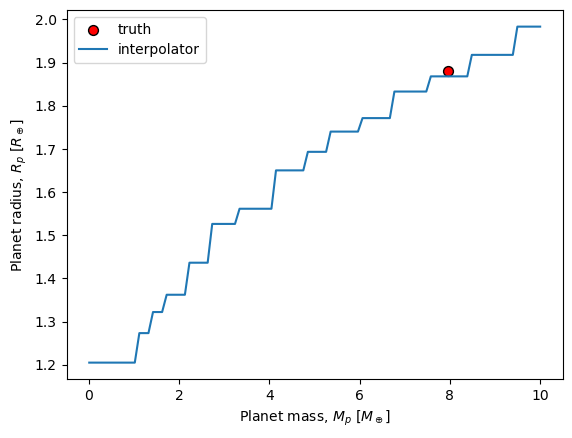

In [10]:
idx = 673

fig,ax = plt.subplots(1,1)

eval_loc = {k: gr.data[k].values[idx]/ia.plot.units[k][0] for k in gr.input_keys}
val_tru = gr.data["r_phot"].values[idx]*ia.plot.units["r_phot"][0]
ax.scatter(eval_loc["mass_tot"], val_tru, s=50, c='r', label="truth", edgecolors='k')

mass_arr = np.linspace(0.01, 10, 100)
val_est = []
for mass in mass_arr:
    eval_loc["mass_tot"] = mass / ia.plot.units["mass_tot"][0]
    val_est.append(interp(*eval_loc.values()))

ax.plot(mass_arr, val_est, label="interpolator")
ax.set(xlabel=ia.plot.units["mass_tot"][2], ylabel=ia.plot.units["r_phot"][2])
ax.legend()

plt.show()